In [1]:
import torch
import numpy as np
from diffusers import ControlNetModel
from src.pipeline_controlnet_inpaint import StableDiffusionControlNetInpaintPipeline
from diffusers.utils import load_image, make_image_grid
from PIL import  Image

/home/perple/anaconda3/envs/animateAnyone/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load ControlNet
controlnet = ControlNetModel.from_pretrained("../ckpts/control_v11p_sd15_inpaint", torch_dtype=torch.float16, variant="fp16")

# pass ControlNet to the pipeline
pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "../ckpts/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16, variant="fp16"
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
pipeline.enable_xformers_memory_efficient_attention()

# load base and mask image
init_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")
mask_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint_mask.png")


# prepare control image
def make_inpaint_condition(init_image, mask_image):
    init_image = np.array(init_image.convert("RGB")).astype(np.float32) / 255.0
    mask_image = np.array(mask_image.convert("L")).astype(np.float32) / 255.0
    assert init_image.shape[0:2] == mask_image.shape[0:2], "image and image_mask must have the same image size"
    init_image[mask_image > 0.5] = -1.0  # set as masked pixel
    init_image = np.expand_dims(init_image, 0).transpose(0, 3, 1, 2)
    init_image = torch.from_numpy(init_image)
    return init_image

control_image = make_inpaint_condition(init_image, mask_image)

Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 13.42it/s]


In [3]:
from omegaconf import OmegaConf
import os
import yaml
import sys
from pathlib import Path
sys.path.insert(0, "/home/perple/lianxu/ControlNetInpaint/lama")
from saicinpainting.evaluation.utils import move_to_device
from saicinpainting.training.trainers import load_checkpoint
from saicinpainting.evaluation.data import pad_tensor_to_modulo
# inpaint with lama model
def inpaint_image_with_lama(
    image: np.ndarray,
    mask: np.ndarray,
    config_path: str,
    ckpt_path: str,
    mod=8,
    device='cuda'
):
    assert len(mask.shape) == 2
    if np.max(mask) == 1:
        mask = mask * 255
    image = torch.from_numpy(image).float().div(255.)
    mask = torch.from_numpy(mask).float()
    predict_config = OmegaConf.load(config_path)
    predict_config.model.path = ckpt_path
    device = torch.device(device)

    train_config_path = os.path.join(
        predict_config.model.path, 'config.yaml')

    with open(train_config_path, 'r') as f:
        train_config = OmegaConf.create(yaml.safe_load(f))

    train_config.training_model.predict_only = True
    train_config.visualizer.kind = 'noop'

    checkpoint_path = os.path.join(
        predict_config.model.path, 'models',
        predict_config.model.checkpoint
    )
    model = load_checkpoint(
        train_config, checkpoint_path, strict=False, map_location='cpu')
    model.freeze()
    if not predict_config.get('refine', False):
        model.to(device)

    batch = {}
    batch['image'] = image.permute(2, 0, 1).unsqueeze(0)
    batch['mask'] = mask[None, None]
    unpad_to_size = [batch['image'].shape[2], batch['image'].shape[3]]
    batch['image'] = pad_tensor_to_modulo(batch['image'], mod)
    batch['mask'] = pad_tensor_to_modulo(batch['mask'], mod)
    batch = move_to_device(batch, device)
    batch['mask'] = (batch['mask'] > 0) * 1

    batch = model(batch)
    cur_res = batch[predict_config.out_key][0].permute(1, 2, 0)
    cur_res = cur_res.detach().cpu().numpy()

    if unpad_to_size is not None:
        orig_height, orig_width = unpad_to_size
        cur_res = cur_res[:orig_height, :orig_width]

    cur_res = np.clip(cur_res * 255, 0, 255).astype('uint8')
    return cur_res


Detectron v2 is not installed


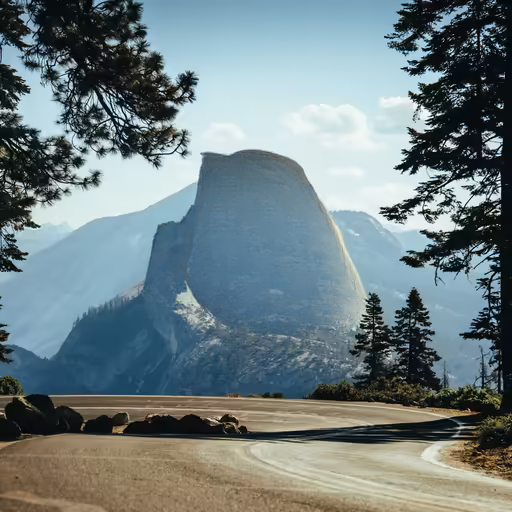

In [4]:
lama_config = "./lama/configs/prediction/default.yaml"
lama_path = "../ckpts/big-lama"
init_image_arr = np.array(init_image)
mask_image_arr = np.array(mask_image)
lama_image_arr = inpaint_image_with_lama(init_image_arr, mask_image_arr, lama_config, lama_path)
Image.fromarray(lama_image_arr)

100%|██████████| 50/50 [00:03<00:00, 12.89it/s]


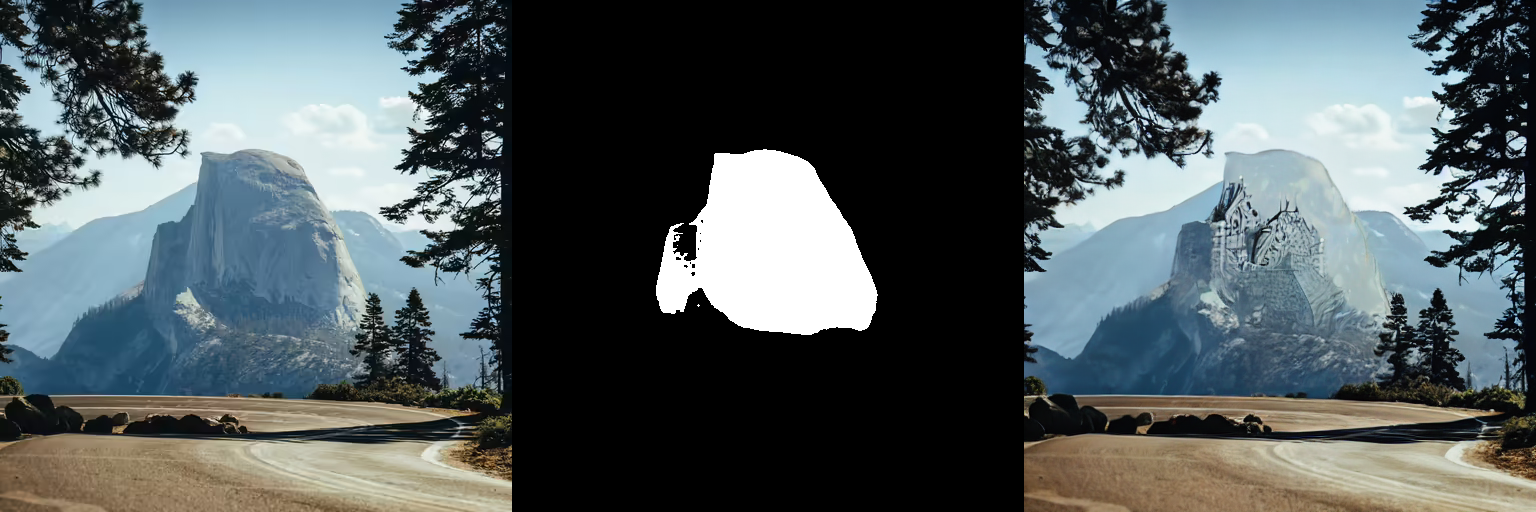

In [8]:
prompt = "concept art digital painting of an elven castle, inspired by lord of the rings, highly detailed, 8k"
lama_image = torch.from_numpy(lama_image_arr).float().div(255.).permute(2, 0, 1).unsqueeze(0)
# image = pipeline(prompt=prompt, image=init_image, mask_image=mask_image, control_image=control_image, lama_image=None).images[0]
image = pipeline(prompt=prompt, image=init_image, mask_image=mask_image, control_image=control_image, lama_image=lama_image).images[0]
make_image_grid([init_image, mask_image, image], rows=1, cols=3)